# Seq2seq Test

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense
from keras.callbacks import History, ReduceLROnPlateau, EarlyStopping
import numpy as np
from livelossplot import PlotLossesKeras

Using TensorFlow backend.


In [8]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 1000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = '../data/test_data/ind.txt'

In [13]:
# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    print(input_text, '--->', target_text)
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

Run! ---> 	Lari!

Who? ---> 	Siapa?

Wow! ---> 	Wow!

Help! ---> 	Tolong!

Jump! ---> 	Lompat!

Jump. ---> 	Loncat.

Stop! ---> 	Berhenti!

Wait! ---> 	Tunggu!

Wait. ---> 	Tunggu.

Hurry! ---> 	Cepatlah!

Hurry! ---> 	Cepat!

Hurry! ---> 	Buruan!

I see. ---> 	Begitu rupanya.

Smile. ---> 	Senyum.

Attack! ---> 	Serang!

Cheers! ---> 	Bersulang!

Freeze! ---> 	Angkat tangan!

Get up. ---> 	Bangunlah.

Got it! ---> 	Aku mengerti!

Got it? ---> 	Mengerti?

Listen. ---> 	Dengar.

No way! ---> 	Tak bisa!

No way! ---> 	Tidak mungkin!

Really? ---> 	Benarkah?

Really? ---> 	Beneran?

Thanks. ---> 	Terima kasih.

Thanks. ---> 	Makasih.

We try. ---> 	Kami mencoba.

Why me? ---> 	Kenapa harus saya?

Awesome! ---> 	Mengagumkan!

Come on! ---> 	Ayo!

Get out! ---> 	Keluar!

Goodbye! ---> 	Sampai jumpa!

Hold it! ---> 	Tahan!

I'm sad. ---> 	Saya sedih.

It's me! ---> 	Ini aku!

Me, too. ---> 	Aku juga.

Perfect! ---> 	Sempurna!

See you! ---> 	Sampai jumpa!

Show me. ---> 	Perlihatkan padaku.


Tom works hard. ---> 	Tom bekerja dengan keras.

Tom's not weak. ---> 	Tom tidak lemah.

We made a deal. ---> 	Kami membuat sebuah kesepakatan.

We'll be happy. ---> 	Kami akan senang.

We're credible. ---> 	Kami dapat dipercaya.

We're sociable. ---> 	Kami seorang yang mudah bergaul.

What's so hard? ---> 	Apa susahnya, sih?

Where were you? ---> 	Tadi kamu di mana?

Where were you? ---> 	Kamu di mana?

Where were you? ---> 	Tadi kau ada di mana?

Where's Boston? ---> 	Boston itu di mana?

Where's my car? ---> 	Mobilku mana?

Whose are they? ---> 	Itu punya siapa?

You have to go. ---> 	Kamu harus pergi.

Are these yours? ---> 	Apa ini milikmu?

Are we done yet? ---> 	Apa kita masih belum selesai?

Are you certain? ---> 	Apakah kamu yakin?

Are you certain? ---> 	Apakah Anda yakin?

Are you certain? ---> 	Apa kau yakin?

Are you in love? ---> 	Apa kamu sedang jatuh cinta?

Are you kidding? ---> 	Apa kau bercanda?

Are you serious? ---> 	Apa kau serius?

Call my husband. ---> 	Panggil 

Tell me the truth. ---> 	Katakan padaku yang sebenarnya.

That house is big. ---> 	Rumah itu besar.

That isn't enough. ---> 	Itu tidak cukup.

That was our home. ---> 	Itu dulunya rumah kami.

That was our home. ---> 	Itu dulunya rumah kita.

That won't happen. ---> 	Itu tidak akan terjadi.

That won't happen. ---> 	Itu tak 'kan terjadi.

That's all I have. ---> 	Ini semua yang saya punya.

That's my brother. ---> 	Itu kakakku.

That's my brother. ---> 	Itu adikku.

That's not enough. ---> 	Itu tidak cukup.

The check, please. ---> 	Tolong bonnya.

The train is here. ---> 	Keretanya di sini.

These are my boys. ---> 	Mereka ini adalah anak-anak laki-lakiku.

They'll try again. ---> 	Mereka akan mencobanya lagi.

This is ludicrous. ---> 	Ini menggelikan.

This is my sister. ---> 	Ini adikku.

This is very cool. ---> 	Ini sangat keren.

This isn't a joke. ---> 	Ini bukan lelucon.

This isn't enough. ---> 	Ini tidak cukup.

Today is Thursday. ---> 	Hari ini hari Kamis.

Tom broke the law

In [14]:
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

In [15]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, 57)     0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, None, 54)     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 256), (None, 321536      input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  318464      input_4[0][0]                    
                                                                 lstm_3[0][1]                     
          

In [16]:
def is_notebook():
    try:
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            return True   # Jupyter notebook or qtconsole
        elif shell == 'TerminalInteractiveShell':
            return False  # Terminal running IPython
        else:
            return False  # Other type (?)
    except NameError:
        return False      # Probably standard Python interpreter

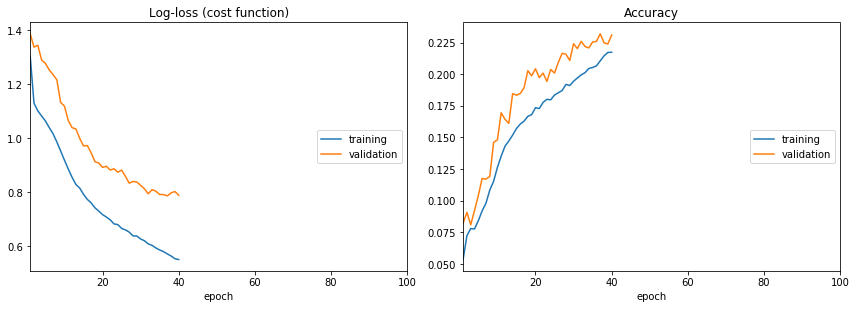

Epoch 00040: early stopping


In [17]:
# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
h = History()
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=0.000001,
                        verbose=1, epsilon=1e-5)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')

callbacks = [h, rlr, early_stop]
if is_notebook():
    callbacks.append(PlotLossesKeras())
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2,
         callbacks=callbacks)

In [18]:
# Save model
# model.save('s2s.h5')

In [19]:
# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


In [20]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence

In [21]:
for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

-
Input sentence: Run!
Decoded sentence: Serangan!

-
Input sentence: Who?
Decoded sentence: Berangita!

-
Input sentence: Wow!
Decoded sentence: Lombang!

-
Input sentence: Help!
Decoded sentence: Serangah sengang!

-
Input sentence: Jump!
Decoded sentence: Serangan!

-
Input sentence: Jump.
Decoded sentence: Serangan!

-
Input sentence: Stop!
Decoded sentence: Seramatih!

-
Input sentence: Wait!
Decoded sentence: Berangita!

-
Input sentence: Wait.
Decoded sentence: Berihat sasah banyang.

-
Input sentence: Hurry!
Decoded sentence: Berangan!

-
Input sentence: Hurry!
Decoded sentence: Berangan!

-
Input sentence: Hurry!
Decoded sentence: Berangan!

-
Input sentence: I see.
Decoded sentence: Aku tidak beranang.

-
Input sentence: Smile.
Decoded sentence: Serama kasah bangan.

-
Input sentence: Attack!
Decoded sentence: Bengerti!

-
Input sentence: Cheers!
Decoded sentence: Terom kani barum.

-
Input sentence: Freeze!
Decoded sentence: Serama kasah bangan.

-
Input sentence: Get up.
De